In [14]:
# #download data
# from huggingface_hub import snapshot_download
# # # Download entire dataset to local folder
# snapshot_download(
# repo_id="chen-yingfa/CFDBench",
# repo_type="dataset",
# local_dir="./CFDBench"
# )

In [1]:
from data_handle.data import Data
from models.FNO import FNO
from training.trainer import Trainer
import torch
from data_handle.testdata import CFDBenchDataset

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True

In [ ]:
model = FNO(in_channels=10, out_channels=2, width=32, modes1=12, modes2=12, n_layers=4, padding=8)

In [17]:
# dataset = CFDBenchDataset(data_root='/root/programs/physics188/physics188Capstone/data/CFDBench', rollout_steps=1)

In [18]:
# dataset.preload_all()

In [19]:
# trainer = Trainer(model, dataset, batch_size=512, lr=1e-3)

In [20]:
# trainer.model.load_state_dict(
#     torch.load('/root/programs/physics188/physics188Capstone/src/training/epochs/FNO_large/model_weights_20.pt', 
#                weights_only=True)
# )

In [21]:
# trainer.train_single_step(epochs=19)

In [22]:
dataset_ar = CFDBenchDataset(data_root='/root/programs/physics188/physics188Capstone/data/CFDBench', rollout_steps=5)

Indexed 739 cases, 240573 samples
Computing normalization stats (streaming)...
Stats: u=1.3686±1.3326, v=1.2876±1.3446


In [23]:
dataset_ar.preload_all()

Preloading 739 cases into RAM...
  Loaded 20/739 cases
  Loaded 40/739 cases
  Loaded 60/739 cases
  Loaded 80/739 cases
  Loaded 100/739 cases
  Loaded 120/739 cases
  Loaded 140/739 cases
  Loaded 160/739 cases
  Loaded 180/739 cases
  Loaded 200/739 cases
  Loaded 220/739 cases
  Loaded 240/739 cases
  Loaded 260/739 cases
  Loaded 280/739 cases
  Loaded 300/739 cases
  Loaded 320/739 cases
  Loaded 340/739 cases
  Loaded 360/739 cases
  Loaded 380/739 cases
  Loaded 400/739 cases
  Loaded 420/739 cases
  Loaded 440/739 cases
  Loaded 460/739 cases
  Loaded 480/739 cases
  Loaded 500/739 cases
  Loaded 520/739 cases
  Loaded 540/739 cases
  Loaded 560/739 cases
  Loaded 580/739 cases
  Loaded 600/739 cases
  Loaded 620/739 cases
  Loaded 640/739 cases
  Loaded 660/739 cases
  Loaded 680/739 cases
  Loaded 700/739 cases
  Loaded 720/739 cases
Preload complete. Estimated RAM usage: 7.5 GB


In [24]:
trainer_ar = Trainer(model, dataset_ar, batch_size=64, lr=1e-4)

Using device: cuda
Train: 191943, Val: 26173, Test: 22457


In [25]:
trainer_ar.model.load_state_dict(
    torch.load('/root/programs/physics188/physics188Capstone/src/training/epochs/FNO_large/model_weights_20.pt', 
               weights_only=True)
)

<All keys matched successfully>

Starting autoregressive training for 30 epochs, rollout=5


Epoch 1/30: 100%|██████████| 3000/3000 [06:56<00:00,  7.21it/s]


Epoch [1/30] - Train: 0.004197, Val: 0.002618, LR: 0.000100, Time: 440.69s


Epoch 2/30: 100%|██████████| 3000/3000 [06:59<00:00,  7.15it/s]


Epoch [2/30] - Train: 0.003299, Val: 0.002513, LR: 0.000100, Time: 444.16s


Epoch 3/30: 100%|██████████| 3000/3000 [06:59<00:00,  7.15it/s]


Epoch [3/30] - Train: 0.002960, Val: 0.003214, LR: 0.000100, Time: 444.07s


Epoch 4/30: 100%|██████████| 3000/3000 [06:59<00:00,  7.14it/s]


Epoch [4/30] - Train: 0.002840, Val: 0.002273, LR: 0.000100, Time: 444.64s


Epoch 5/30: 100%|██████████| 3000/3000 [07:00<00:00,  7.13it/s]


Epoch [5/30] - Train: 0.002714, Val: 0.002185, LR: 0.000100, Time: 445.13s


Epoch 6/30: 100%|██████████| 3000/3000 [06:59<00:00,  7.15it/s]


Epoch [6/30] - Train: 0.002642, Val: 0.002490, LR: 0.000100, Time: 444.23s


Epoch 7/30: 100%|██████████| 3000/3000 [06:59<00:00,  7.16it/s]


Epoch [7/30] - Train: 0.002523, Val: 0.002077, LR: 0.000100, Time: 443.49s


Epoch 8/30: 100%|██████████| 3000/3000 [06:59<00:00,  7.16it/s]


Epoch [8/30] - Train: 0.002519, Val: 0.002474, LR: 0.000100, Time: 443.41s


Epoch 9/30: 100%|██████████| 3000/3000 [06:59<00:00,  7.15it/s]


Epoch [9/30] - Train: 0.002435, Val: 0.002499, LR: 0.000100, Time: 443.82s


Epoch 10/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.16it/s]


Epoch [10/30] - Train: 0.002384, Val: 0.002047, LR: 0.000100, Time: 443.20s


Epoch 11/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


Epoch [11/30] - Train: 0.002274, Val: 0.002408, LR: 0.000100, Time: 442.83s


Epoch 12/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


Epoch [12/30] - Train: 0.002281, Val: 0.002032, LR: 0.000100, Time: 442.80s


Epoch 13/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


Epoch [13/30] - Train: 0.002209, Val: 0.002253, LR: 0.000100, Time: 442.75s


Epoch 14/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


Epoch [14/30] - Train: 0.002220, Val: 0.001938, LR: 0.000100, Time: 442.58s


Epoch 15/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


Epoch [15/30] - Train: 0.002149, Val: 0.001708, LR: 0.000100, Time: 442.55s


Epoch 16/30: 100%|██████████| 3000/3000 [06:57<00:00,  7.18it/s]


Epoch [16/30] - Train: 0.002165, Val: 0.001882, LR: 0.000100, Time: 442.08s


Epoch 17/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


Epoch [17/30] - Train: 0.002102, Val: 0.001980, LR: 0.000100, Time: 442.88s


Epoch 18/30: 100%|██████████| 3000/3000 [06:57<00:00,  7.18it/s]


Epoch [18/30] - Train: 0.002041, Val: 0.001903, LR: 0.000100, Time: 442.09s


Epoch 19/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


Epoch [19/30] - Train: 0.002011, Val: 0.001706, LR: 0.000100, Time: 442.77s


Epoch 20/30: 100%|██████████| 3000/3000 [06:57<00:00,  7.18it/s]


Epoch [20/30] - Train: 0.002068, Val: 0.002355, LR: 0.000100, Time: 442.09s


Epoch 21/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


Epoch [21/30] - Train: 0.001986, Val: 0.001776, LR: 0.000100, Time: 442.82s


Epoch 22/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


Epoch [22/30] - Train: 0.001983, Val: 0.001768, LR: 0.000100, Time: 442.59s


Epoch 23/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


Epoch [23/30] - Train: 0.001937, Val: 0.001985, LR: 0.000100, Time: 442.83s


Epoch 24/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


Epoch [24/30] - Train: 0.001945, Val: 0.001921, LR: 0.000100, Time: 442.89s


Epoch 25/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.18it/s]


Epoch [25/30] - Train: 0.001971, Val: 0.001851, LR: 0.000100, Time: 442.35s


Epoch 26/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


Epoch [26/30] - Train: 0.001877, Val: 0.002167, LR: 0.000100, Time: 443.19s


Epoch 27/30: 100%|██████████| 3000/3000 [08:01<00:00,  6.24it/s]


Epoch [27/30] - Train: 0.001943, Val: 0.001975, LR: 0.000100, Time: 505.49s


Epoch 28/30: 100%|██████████| 3000/3000 [06:59<00:00,  7.15it/s]


Epoch [28/30] - Train: 0.001829, Val: 0.001742, LR: 0.000100, Time: 443.90s


Epoch 29/30: 100%|██████████| 3000/3000 [09:17<00:00,  5.38it/s]  


Epoch [29/30] - Train: 0.001804, Val: 0.001570, LR: 0.000100, Time: 582.27s


Epoch 30/30: 100%|██████████| 3000/3000 [06:58<00:00,  7.16it/s]


Epoch [30/30] - Train: 0.001855, Val: 0.001616, LR: 0.000100, Time: 443.24s


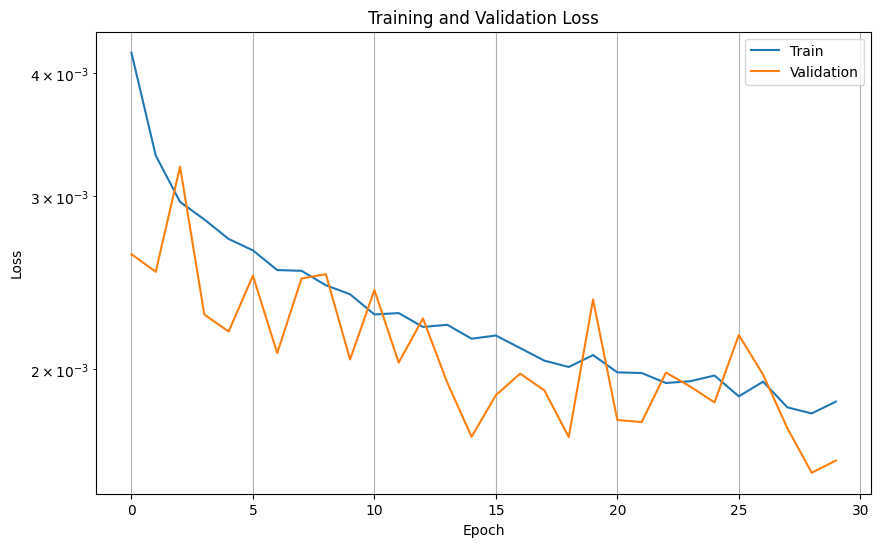

Training completed!


In [26]:
trainer_ar.train_autoregressive(epochs=30, rollout_steps=5)

In [27]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

In [28]:
# def visualize_prediction(
#     model: torch.nn.Module,
#     dataset,
#     checkpoint_path: str = None,
#     device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
#     sample_idx: int = None,
#     rollout_step: int = 0,  # which timestep to visualize
#     figsize: tuple = (16, 8)
# ):
#     """
#     Visualize model prediction vs ground truth.
    
#     Args:
#         model: FNO model
#         dataset: test dataset
#         checkpoint_path: path to model weights (optional if already loaded)
#         device: device to run inference on
#         sample_idx: specific sample index (random if None)
#         rollout_step: which future timestep to visualize (0 to rollout_steps-1)
#         figsize: figure size
#     """
#     model = model.to(device)
    
#     # Load weights if provided
#     if checkpoint_path:
#         model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    
#     model.eval()
    
#     # Get random sample if not specified
#     if sample_idx is None:
#         sample_idx = np.random.randint(0, len(dataset))
    
#     x, y = dataset[sample_idx]
#     x = x.unsqueeze(0).to(device)  # [1, H, W, C]
#     y = y.to(device)                # [T, H, W, 2] or [H, W, 2]
    
#     # Get target for the specified rollout step
#     if y.dim() == 4:
#         target = y[rollout_step]  # [H, W, 2]
#     else:
#         target = y  # [H, W, 2]
    
#     # Run inference
#     with torch.no_grad():
#         pred = model(x).squeeze(0)  # [H, W, 2]
    
#     # Compute error
#     error = (pred - target).abs()
    
#     # Move to CPU for plotting
#     x_np = x.squeeze(0).cpu().numpy()
#     target_np = target.cpu().numpy()
#     pred_np = pred.cpu().numpy()
#     error_np = error.cpu().numpy()
    
#     # Create figure: 2 rows (u_x, u_y) x 4 cols (input, target, pred, error)
#     fig, axes = plt.subplots(2, 4, figsize=figsize)
    
#     channel_names = ['$u_x$', '$u_y$']
#     col_titles = ['Input', 'Ground Truth', 'Prediction', 'Absolute Error']
    
#     for row, (name, ch) in enumerate(zip(channel_names, [0, 1])):
#         # Input (velocity component from input)
#         im0 = axes[row, 0].imshow(x_np[:, :, ch], cmap='RdBu_r')
#         plt.colorbar(im0, ax=axes[row, 0], fraction=0.046)
        
#         # Ground truth
#         im1 = axes[row, 1].imshow(target_np[:, :, ch], cmap='RdBu_r')
#         plt.colorbar(im1, ax=axes[row, 1], fraction=0.046)
        
#         # Prediction
#         im2 = axes[row, 2].imshow(pred_np[:, :, ch], cmap='RdBu_r')
#         plt.colorbar(im2, ax=axes[row, 2], fraction=0.046)
        
#         # Error
#         im3 = axes[row, 3].imshow(error_np[:, :, ch], cmap='hot')
#         plt.colorbar(im3, ax=axes[row, 3], fraction=0.046)
        
#         # Row labels
#         axes[row, 0].set_ylabel(name, fontsize=12)
    
#     # Column titles
#     for col, title in enumerate(col_titles):
#         axes[0, col].set_title(title, fontsize=12)
    
#     # Remove ticks
#     for ax in axes.flat:
#         ax.set_xticks([])
#         ax.set_yticks([])
    
#     plt.suptitle(f'Sample {sample_idx} | Rollout Step {rollout_step}', fontsize=14)
#     plt.tight_layout()
#     plt.show()
    
#     # Print error statistics
#     mae_ux = error_np[:, :, 0].mean()
#     mae_uy = error_np[:, :, 1].mean()
#     mae_total = error_np.mean()
    
#     print(f"Mean Absolute Error:")
#     print(f"  u_x: {mae_ux:.6f}")
#     print(f"  u_y: {mae_uy:.6f}")
#     print(f"  Total: {mae_total:.6f}")
    
#     return pred_np, target_np, error_np


In [29]:
# pred, target, error = visualize_prediction(model, trainer.test_set, '/home/babay/programs/physics188/capstone/project/SHMS/src/training/epochs/model_weights_6')